## Digital approach to solving a QUBO: using QAOA and Linear Entanglement Ansatz.

In [1]:
from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import transpile 
from qiskit_aer import AerSimulator

First we use LoadData to load all the 3D RISM slices of some protein and (scaled) register positions of the corresponding QPU. Then we use Qubo to compute the corresponding QUBO matrices and Ising Hamiltonians.

In [14]:
# LoadData does all the file loading.
ld = LoadData(protein='MUP1')
# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld.densities, ld.rescaled_register_positions)

We pick one QUBO matrix Ising Hamiltonian from the Qubo object and use that to define the ansatzes.

In [13]:
# Use the first slice as an example to solve.
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# Print the qubo matrix.
qubo

array([[-0.01074377,  0.04727714,  0.04727714,  0.04727714],
       [ 0.04727714, -0.00892812,  0.03218907,  0.04727714],
       [ 0.04727714,  0.03218907, -0.00865155,  0.04727714],
       [ 0.04727714,  0.04727714,  0.04727714, -0.00969204]])

Qubo object also has a function that computes the optimal bitstring and corresponding energy using classical brute-force approach.

In [10]:
# classical brute-force solution
solution = q.find_optimum(qubo=qubo)
solution

('1111111111111111', -8.116032227162112)

For illustration, here is a drawing of the Linear Entanglement ansatz.

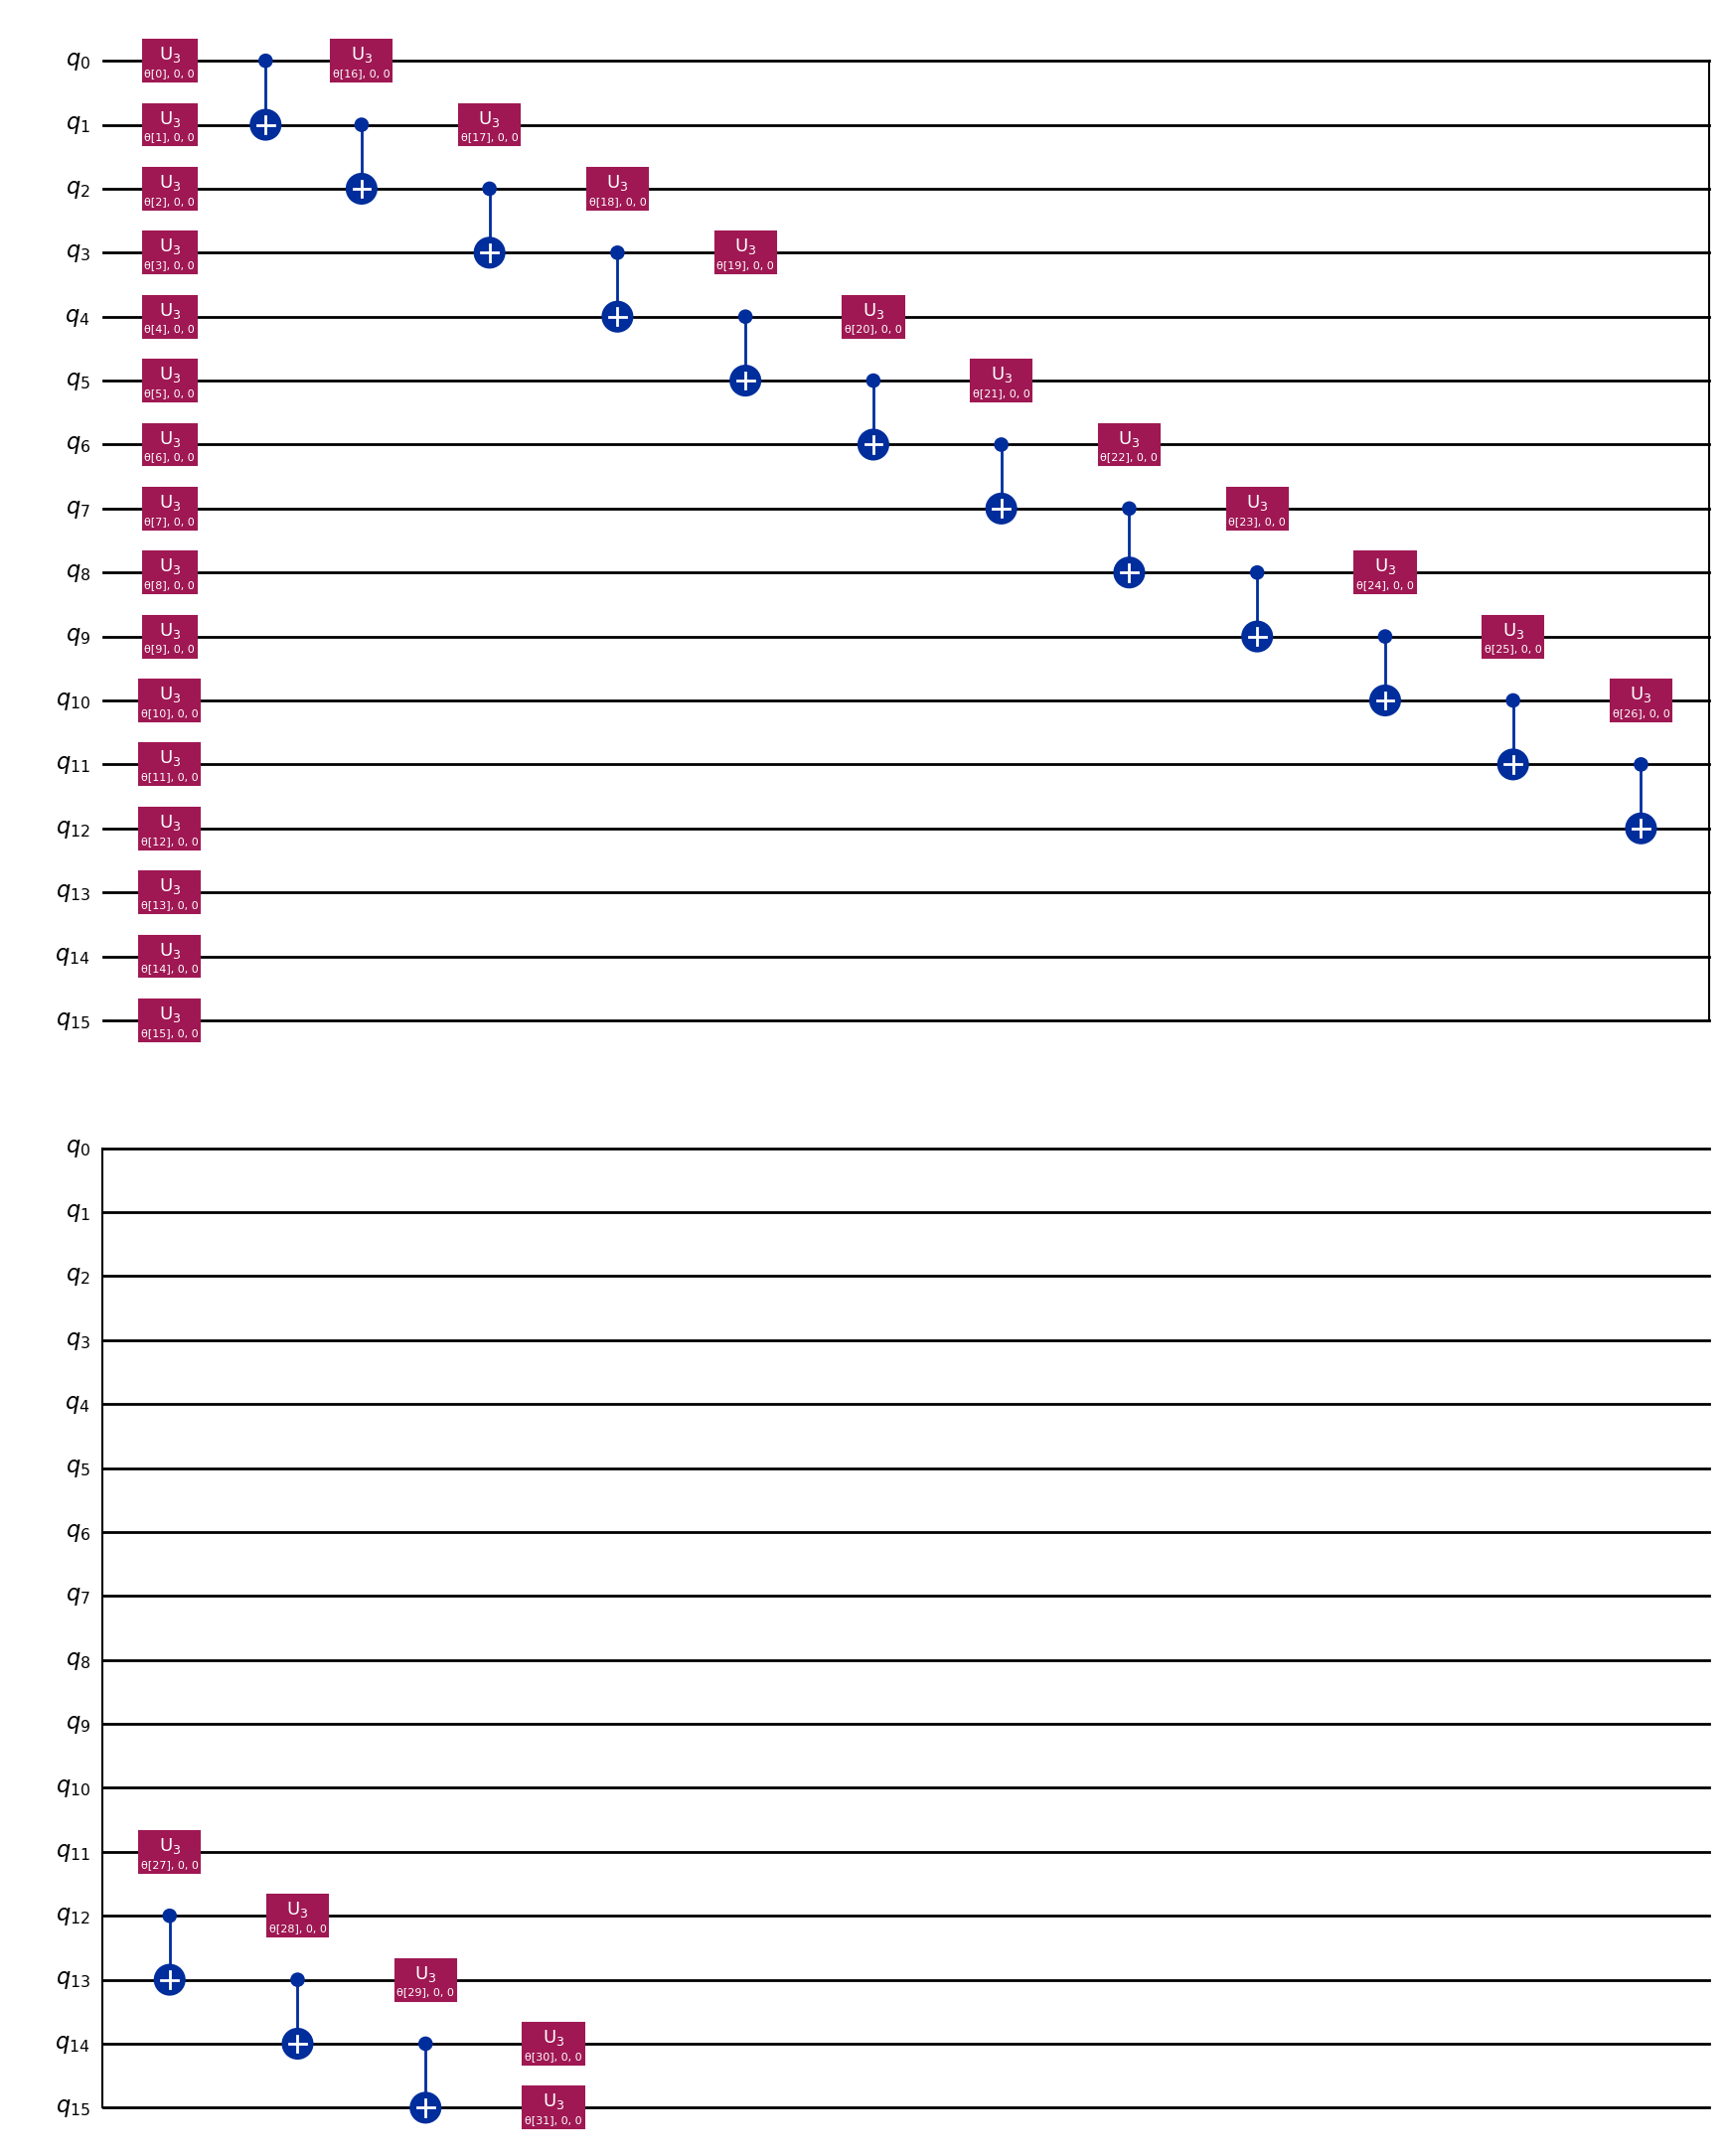

In [5]:
# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

# Drawing of the Linear Entanglement ansatz circuit.
basis_gates=['u1', 'u2', 'u3', 'cx']
ansatz_transpiled = transpile(le_ansatz, AerSimulator(), basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
ansatz_transpiled.draw('mpl', style='iqp')

Now that we have defined the qubo and ansatzes to be used, we use the VQE module to apply the variational approach. VQE accepts a qubo matrix, an ansatz, a sampler and initial parameters.

In [14]:
# EXAMPLE: QAQA

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

alpha = 0.5 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

/var/folders/lg/jbb7l6y11_343nxvjxmyhh8h0000gn/T/ipykernel_83312/4227213039.py:5: DeprecationWarning: All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. These classes are deprecated as of qiskit 0.46.0 and will be removed in qiskit 1.0.0. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. If you are using a custom fake backend implementation, you don't need to take any action.
  backend = AerSimulator().from_backend(FakeKolkata())


[['1000', 0.0617, -0.010743767178636635],
 ['1000', 0.0633, -0.010743767178636635],
 ['1000', 0.0673, -0.010743767178636635],
 ['1000', 0.0781, -0.010743767178636635],
 ['1000', 0.0622, -0.010743767178636635],
 ['1000', 0.0719, -0.010743767178636635],
 ['1000', 0.0764, -0.010743767178636635],
 ['1000', 0.0714, -0.010743767178636635],
 ['1000', 0.0764, -0.010743767178636635],
 ['1000', 0.0792, -0.010743767178636635]]

In [7]:
# EXAMPLE: LE
np.random.seed(1)

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

alpha = 0.5 # confidence level for CVaR

params_le = np.array([np.random.random()]*le_ansatz.num_parameters)
vqe_le = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_le, prob_opt_sol=True)

# Now run the minimization procedure.
vqe_le.run(alpha=alpha, maxiter=20)

# history records the probability of lowest sampled energy at each iteration.
vqe_le.history

[['1000', 0.0394, -0.010743767178636635],
 ['1000', 0.0038, -0.010743767178636635],
 ['1000', 0.1537, -0.010743767178636635],
 ['1000', 0.1322, -0.010743767178636635],
 ['1000', 0.1264, -0.010743767178636635],
 ['1000', 0.0042, -0.010743767178636635],
 ['1000', 0.188, -0.010743767178636635],
 ['1000', 0.1586, -0.010743767178636635],
 ['1000', 0.1648, -0.010743767178636635],
 ['1000', 0.0081, -0.010743767178636635],
 ['1000', 0.2082, -0.010743767178636635],
 ['1000', 0.2552, -0.010743767178636635],
 ['1000', 0.2093, -0.010743767178636635],
 ['1000', 0.2925, -0.010743767178636635],
 ['1000', 0.2146, -0.010743767178636635],
 ['1000', 0.0932, -0.010743767178636635],
 ['1000', 0.1898, -0.010743767178636635],
 ['1000', 0.2748, -0.010743767178636635],
 ['1000', 0.1694, -0.010743767178636635],
 ['1000', 0.2483, -0.010743767178636635]]

The QUBO we solved is from a 3D RISM file. If you want to solve an arbitrary QUBO, we can do that as well.

In [8]:
# Define the QUBO matrix that you want to solve. Here we use a random symmetric matrix.

np.random.seed(1)
n = 4  # Size of the matrix
random_matrix = np.random.uniform(-0.5, 0.5, size=(n, n))
Q = (random_matrix + random_matrix.T)/2


# Now, the workflow is the same as above: define your favorite ansatz and minimize.
num_qubits = len(Q)
full_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='full', reps=1)

alpha = 0.5 # confidence level for CVaR

params_full = np.array([np.random.random()]*full_ansatz.num_parameters)
vqe_full = VQE(qubo=Q, ansatz=full_ansatz, sampler=sampler, params=params_full, prob_opt_sol=True)

# Now run the minimization procedure.
vqe_full.run(alpha=alpha, maxiter=20)

# History records the probability of lowest sampled energy at each iteration.
vqe_full.history

[['1111', 0.669, -1.9688681178665814],
 ['1111', 0.4321, -1.9688681178665814],
 ['1111', 0.4274, -1.9688681178665814],
 ['1111', 0.3978, -1.9688681178665814],
 ['1111', 0.268, -1.9688681178665814],
 ['1111', 0.4314, -1.9688681178665814],
 ['1111', 0.4505, -1.9688681178665814],
 ['1111', 0.4356, -1.9688681178665814],
 ['1111', 0.3197, -1.9688681178665814],
 ['1111', 0.8672, -1.9688681178665814],
 ['1111', 0.9088, -1.9688681178665814],
 ['1111', 0.8942, -1.9688681178665814],
 ['1111', 0.9358, -1.9688681178665814],
 ['1111', 0.843, -1.9688681178665814],
 ['1111', 0.8388, -1.9688681178665814],
 ['1111', 0.8712, -1.9688681178665814],
 ['1111', 0.8571, -1.9688681178665814],
 ['1111', 0.8469, -1.9688681178665814],
 ['1111', 0.7578, -1.9688681178665814],
 ['1111', 0.8573, -1.9688681178665814]]